# The survival of the Gaussian distribution

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import corner
import sys 
import h5py
from scipy import stats
from scipy import optimize
import multiprocessing as mp
sys.path.append("../code/")
import perform_all_fits as paf
from path_handler import PathHandler
ph = PathHandler()

## Build the model

$$ f(x) = (1-\alpha) \mathcal{N}(x|\mu,\sigma) + \alpha \Gamma(x|\vec{\theta})$$

$\mathcal{N}$ is my gaussian distribution, and $\Gamma$ is a right skew distribution, i.e. the gamma dist. $\alpha$ is a weighting parameter that dictates how much each component weights towards the final signal 

## Load in the fitting results

In [2]:
# output name 
foldername ="EQ6_divided_by_EQ2"
filename = "band_depth_ratio_survival_gauss_gamma_fits.hdf5"
outfname=ph.global_distributions(foldername,filename)

In [3]:
myoutdata = h5py.File(outfname,"r")

In [4]:
model_parameter=myoutdata['model_parameter'][:]
model_parameter_names=myoutdata['model_parameter_names'][:]
surface_content_parameter_names=myoutdata['surface_content_parameter_names'][:]
surface_content_parameters=myoutdata['surface_content_parameters'][:]

In [5]:
## Discard the failed fits
drop_critera=surface_content_parameters[:,0]==1
my_results = surface_content_parameters[~drop_critera]

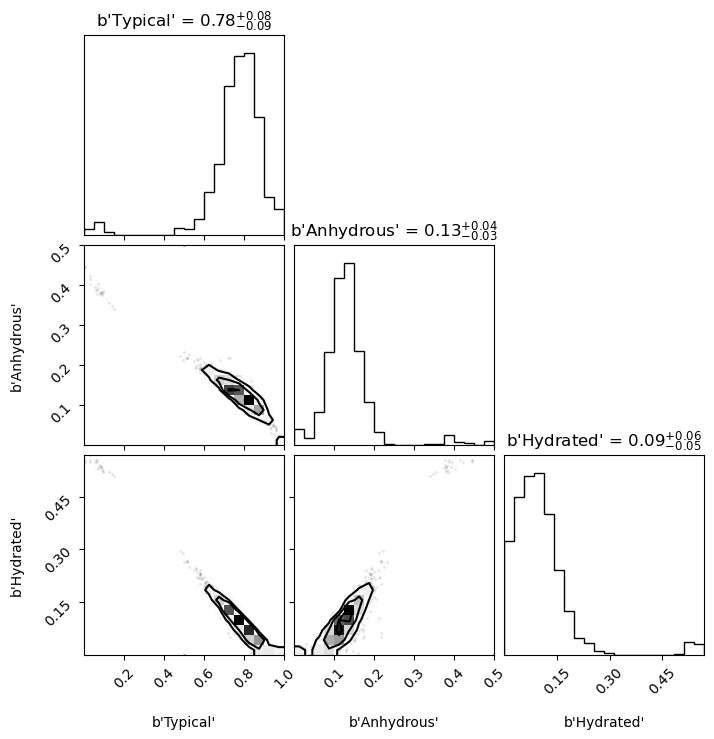

In [6]:

corner.corner(my_results,labels=surface_content_parameter_names,show_titles=True);

### Load the band-depth ratio's

In [7]:
EQ2, EQ6 = paf.open_EQ2_EQ6_band_depths()

make an example plot of the global dist

In [12]:
# pick an exampled globla distribution
jj = 100
ratio = EQ6[:,jj]/EQ2[:,jj]
ratio = ratio[np.isfinite(ratio)]

prepare the histogram

In [13]:
nbins = int(np.ceil(np.sqrt(ratio.shape[0])))
counts,bins = np.histogram(ratio,bins=nbins,density=True)
centers = (bins[:-1]+bins[1:])/2

show the model fit

In [14]:
normal,gamma = paf.my_model_gamma(centers,*model_parameter[jj,:])
total = normal+gamma

In [56]:
hydrousconditions = centers >= 1
anhydrousconditions = centers <= 1

set the plot properties

In [57]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.linewidth': 1})

In [70]:
histprop={'histtype':'step','lw':2,'color':'k',"alpha":0.2,'label':'Data'}
totalprop={'lw':2,'color':'k',"ls":'-','label':r'$\mathcal{N}+\Gamma$'}
normalprop={'lw':1,'color':'k',"ls":'-.','label':r'$\mathcal{N}$'}
gammaprop={'lw':1,'color':'k',"ls":':','label':r'$\Gamma$'}

In [71]:
xlabel=r"EQ6/EQ2 band depth ratio"
AXIS = {"yticks":[],"ylabel":r"$\mathcal{P}$","xlabel":xlabel}

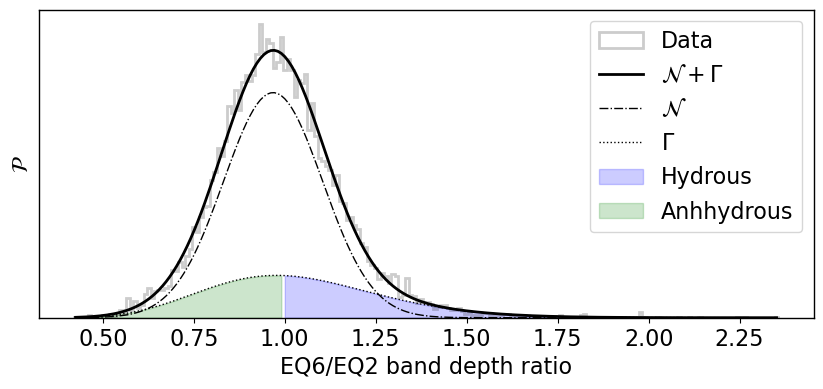

In [72]:
fig,axis=plt.subplots(1,1,figsize=(10,4));
axis.hist(ratio,bins=nbins,density=True,**histprop);
axis.plot(centers,total,**totalprop);
axis.plot(centers,normal,**normalprop);
axis.plot(centers,gamma,**gammaprop);
axis.fill_between(centers,gamma,where=hydrousconditions,alpha=0.2,color='b',label='Hydrous')
axis.fill_between(centers,gamma,where=anhydrousconditions,alpha=0.2,color='g',label='Anhhydrous')
axis.set(**AXIS)
axis.legend()

## Do a global map